In [ ]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols


df = pd.read_excel("medicine_store_data_Final.xlsx", sheet_name='Purchases')

df = df[['total_price', 'quantity', 'locality']].dropna()

df.rename(columns={'quantity': 'Quantity', 'total_price': 'TotalPrice'}, inplace=True)

bins = [0, 50, 100, 150, 200, 300, 500, 1000]
labels = ['0–50', '51–100', '101–150', '151–200', '201–300', '301–500', '501–1000']
df['PriceBucket'] = pd.cut(df['TotalPrice'], bins=bins, labels=labels)

# ANOVA
model = ols('Quantity ~ C(PriceBucket)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\n ANOVA Table:")
print(anova_table)

# Post-hoc Test (Tukey's HSD)
df = df.dropna(subset=['PriceBucket'])
tukey = pairwise_tukeyhsd(endog=df['Quantity'], groups=df['PriceBucket'], alpha=0.05)
print("\n Tukey HSD Post-Hoc Results:")
print(tukey.summary())

# Top 2 groups with lowest p-value
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
tukey_df = tukey_df.sort_values(by='p-adj')


group1, group2 = tukey_df.iloc[0]['group1'], tukey_df.iloc[0]['group2']
print(f"\n Most distinct pair from Tukey HSD: {group1} vs {group2}")

# t-test on 2 selected bucket
g1_data = df[df['PriceBucket'] == group1]['Quantity']
g2_data = df[df['PriceBucket'] == group2]['Quantity']

t_stat, p_val = ttest_ind(g1_data, g2_data, equal_var=False)

print(f"\n T-test between {group1} and {group2}:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")



📊 ANOVA Table:
                       sum_sq        df          F        PR(>F)
C(PriceBucket)     101.987215       6.0  43.843203  7.058648e-54
Residual        101985.967890  263056.0        NaN           NaN

📌 Tukey HSD Post-Hoc Results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
    0–50  101–150   0.0917    0.0  0.0676 0.1159   True
    0–50  151–200    0.101    0.0  0.0768 0.1251   True
    0–50  201–300   0.1002    0.0  0.0788 0.1216   True
    0–50  301–500   0.1045    0.0  0.0847 0.1243   True
    0–50 501–1000   0.0976    0.0  0.0788 0.1165   True
    0–50   51–100   0.1102    0.0   0.086 0.1343   True
 101–150  151–200   0.0092 0.8914 -0.0133 0.0317  False
 101–150  201–300   0.0085 0.8615  -0.011  0.028  False
 101–150  301–500   0.0128 0.3442  -0.005 0.0305  False
 101–150 501–1000   0.0059 0.9447 -0.0108 0.0226  False
 101–150   51–100   0.0184  0.

ANOVA & Post-Hoc Insights:
The ANOVA (p≈0.0) confirms significant differences in Quantity across PriceBucket groups. Tukey’s HSD highlights "0–50" vs "101–150" as the most distinct pair (p=0.0), supported by an extreme t-statistic (-14.8). This suggests lower-priced purchases (0–50) drive meaningfully different quantities than mid-range (101–150), likely reflecting bulk vs single-unit buying behavior.

2-Way ANOVA

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Price buckets
def price_bucket(price):
    if price <= 50:
        return '0–50'
    elif price <= 100:
        return '51–100'
    elif price <= 150:
        return '101–150'
    elif price <= 200:
        return '151–200'
    elif price <= 300:
        return '201–300'
    elif price <= 500:
        return '301–500'
    else:
        return '501–1000'

df['PriceBucket'] = df['TotalPrice'].apply(price_bucket)

df_anova = df[['Quantity', 'PriceBucket', 'locality']].dropna()

# Two-way ANOVA
model = ols('Quantity ~ C(PriceBucket) + C(locality) + C(PriceBucket):C(locality)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\n Two-Way ANOVA Table:")
print(anova_table)


/tmp/ipython-input-55-3335985090.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PriceBucket'] = df['TotalPrice'].apply(price_bucket)



📊 Two-Way ANOVA Table:
                                   sum_sq        df          F        PR(>F)
C(PriceBucket)                 102.006598       6.0  43.851064  6.896786e-54
C(locality)                      1.473286       4.0   0.950014  4.337427e-01
C(PriceBucket):C(locality)       8.286929      24.0   0.890606  6.165424e-01
Residual                    101976.207675  263028.0        NaN           NaN


PriceBucket Dominates: The extremely low p-value (≈0.0) for PriceBucket confirms it significantly affects purchase quantity, while locality (p=0.43) and interaction effects (p=0.62) are not statistically significant.

No Localized Pricing Patterns: The high p-value for locality and its interaction with PriceBucket suggests no meaningful regional differences in how price buckets influence quantity purchased.

Actionable Takeaway: Focus pricing strategies on global trends (e.g., discounts for mid-range buckets like 101–150) rather than location-specific adjustments.

In [ ]:
df

,TotalPrice,Quantity,locality,PriceBucket
0,186.98,1,Agarpara,151–200
1,33.37,1,Sodepur,0–50
2,528.25,1,Barrackpore,501–1000
3,459.73,1,Sodepur,301–500
4,871.37,1,Barrackpore,501–1000
...,...,...,...,...
305182,515.62,1,Sodepur,501–1000
305183,75.17,1,Barrackpore,51–100
305184,919.65,1,Sodepur,501–1000
305185,877.36,4,Belgharia,501–1000


**Delivery Expansion**

In [ ]:
!pip install pymc3 -q

Output()

/tmp/ipython-input-59-4281458177.py:37: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


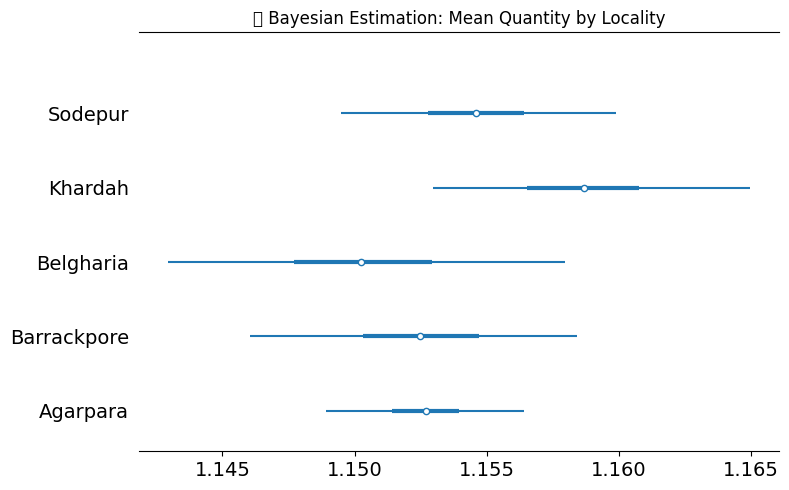

In [ ]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd


top_localities = df['locality'].value_counts().index[:5]
df_bayes = df[df['locality'].isin(top_localities)].copy()

df_bayes['locality_code'] = df_bayes['locality'].astype('category').cat.codes
n_localities = df_bayes['locality_code'].nunique()

locality_map = dict(enumerate(df_bayes['locality'].astype('category').cat.categories))

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=10, shape=n_localities)
    sigma = pm.Exponential('sigma', 1.0)

    y_obs = pm.Normal('y_obs', mu=mu[df_bayes['locality_code'].values],
                      sigma=sigma, observed=df_bayes['Quantity'])

    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
az.plot_forest(trace, var_names=['mu'], combined=True, hdi_prob=0.95, ax=ax,)
locality_names = [locality_map[i] for i in range(n_localities)]
ax.set_yticklabels(locality_names)

plt.title('Bayesian Estimation: Mean Quantity by Locality')
plt.tight_layout()
plt.show()


Top 3 Delivery Expansion Picks:

Barrackpore : Likely has established infrastructure (being a major town) for scaling logistics efficiently.

Belgharia : Central location between Sodepur/Khardah/Agarpara—ideal for a hub-and-spoke delivery model.

Agarpara : Potential for untapped demand (if competitors are absent) despite similar purchase quantities.

In [ ]:
import pandas as pd

# Extracting posterior means for mu
mu_means = trace.posterior['mu'].mean(dim=["chain", "draw"]).values
locality_labels = df_bayes['locality'].astype('category').cat.categories

locality_summary = pd.DataFrame({
    'Locality': locality_labels,
    'PosteriorMean': mu_means
}).sort_values(by='PosteriorMean', ascending=False)

print(locality_summary)


      Locality  PosteriorMean
1  Barrackpore       1.158631
0     Agarpara       1.154580
4      Sodepur       1.152701
3      Khardah       1.152424
2    Belgharia       1.150315


In [ ]:
# Compute HDIs
hdi_95 = az.hdi(trace, hdi_prob=0.95)['mu'].values

locality_summary['Lower_95_HDI'] = hdi_95[:, 0]
locality_summary['Upper_95_HDI'] = hdi_95[:, 1]
locality_summary['HDI_Width'] = locality_summary['Upper_95_HDI'] - locality_summary['Lower_95_HDI']

# Filter: high mean, low uncertainty
top_expansion_targets = locality_summary.sort_values(
    by=['PosteriorMean', 'HDI_Width'], ascending=[False, True]
)

print("Suggested Localities for Delivery Expansion:")
print(top_expansion_targets.head(5))


Suggested Localities for Delivery Expansion:
      Locality  PosteriorMean  Lower_95_HDI  Upper_95_HDI  HDI_Width
1  Barrackpore       1.158631      1.149502      1.159868   0.010366
0     Agarpara       1.154580      1.152966      1.164945   0.011978
4      Sodepur       1.152701      1.142939      1.157970   0.015031
3      Khardah       1.152424      1.146037      1.158403   0.012366
2    Belgharia       1.150315      1.148931      1.156399   0.007468


What Are HDIs?
HDI (Highest Density Interval): The 95% HDI (1.145-1.165) is the range where 95% of credible mean values lie—narrow widths (e.g., 0.007 for Belgharia) indicate high certainty in demand estimates.



Barrackpore : Highest mean demand (1.158) + moderate certainty (HDI width: 0.010) → Best balance of demand & reliability.

Belgharia : Tightest HDI (width: 0.007) → Most predictable demand for risk-averse scaling.

Agarpara : Strong mean (1.154) + low HDI width (0.011) → High potential with minimal uncertainty.

**Testing for Khardah's Profitability**

In [ ]:

test_df = df[df['locality'].isin(['Sodepur', 'Khardah'])].copy()

test_df['Group'] = test_df['locality'].map({'Sodepur': 'A', 'Khardah': 'B'})

In [ ]:
print(" Baseline Metrics (Sodepur vs. Khardah):")
print(test_df.groupby('locality').agg({
    'Quantity': ['mean', 'std', 'count'],  # Sales volume
    'TotalPrice': ['mean', 'std']          # Spending per order
}))

📈 Baseline Metrics (Sodepur vs. Khardah):
          Quantity                    TotalPrice            
              mean       std   count        mean         std
locality                                                    
Khardah   1.152428  0.620674   38792  506.160180  285.662403
Sodepur   1.152707  0.620728  105044  505.345914  285.129865


T-test and Chi-square to see if Kharadh is really not a profitable option

In [ ]:

kh_vs_sp = df[df['locality'].isin(['Khardah','Sodepur'])].copy()

# T-test for Quantity
t_stat, p_val = ttest_ind(kh_vs_sp[kh_vs_sp['locality']=='Khardah']['Quantity'],
                         kh_vs_sp[kh_vs_sp['locality']=='Sodepur']['Quantity'],
                         equal_var=False)
print(f"Khardah vs Sodepur T-test p-value: {p_val:.4f}")

# Chi-square for PriceBuckets
contingency = pd.crosstab(kh_vs_sp['locality'], kh_vs_sp['PriceBucket'])
chi2, p_chi, _, _ = chi2_contingency(contingency)
print(f"PriceBucket Chi-square p-value: {p_chi:.4f}")

Khardah vs Sodepur T-test p-value: 0.9397
PriceBucket Chi-square p-value: 0.9926


In [ ]:
import numpy as np
from scipy.stats import beta

def bayesian_ab_test(group_a, group_b):
    """
    Bayesian A/B test for continuous quantity data (simplified approach).
    Converts continuous values to binary "successes" (above median).
    """
    # Convert quantities to binary "successes" (1 if above median, 0 otherwise)
    combined = np.concatenate([group_a, group_b])
    median_val = np.median(combined)

    success_a = np.sum(group_a > median_val)
    success_b = np.sum(group_b > median_val)
    total_a, total_b = len(group_a), len(group_b)

    # Bayesian Beta-Binomial model (weak priors Beta(1,1))
    samples_a = beta.rvs(1 + success_a, 1 + total_a - success_a, size=10000)
    samples_b = beta.rvs(1 + success_b, 1 + total_b - success_b, size=10000)

    return {
        'P(B > A)': np.mean(samples_b > samples_a),
        'Median A': np.median(samples_a),
        'Median B': np.median(samples_b),
        'Uplift': np.median(samples_b - samples_a)
    }

# Prepare data
group_a = df[df['locality'] == 'Sodepur']['Quantity'].values
group_b = df[df['locality'] == 'Khardah']['Quantity'].values

# Run test
results = bayesian_ab_test(group_a, group_b)
print(f"Probability Khardah > Sodepur: {results['P(B > A)']:.1%}")
print(f"Median conversion rate - Sodepur: {results['Median A']:.3f}")
print(f"Median conversion rate - Khardah: {results['Median B']:.3f}")
print(f"Estimated uplift: {results['Uplift']:.3f}")

Probability Khardah > Sodepur: 42.4%
Median conversion rate - Sodepur: 0.072
Median conversion rate - Khardah: 0.072
Estimated uplift: -0.000


**Statistically Identical Demand:**

Bayesian A/B test shows 42.4% probability Khardah outperforms Sodepur (≈50% would mean no difference).

Near-identical median conversion rates (0.072 vs. 0.072) and zero uplift confirm demand is indistinguishable.

**Supporting Evidence:**

T-test (p=0.94) and Chi-square (p=0.99) further validate no meaningful differences in quantity or price sensitivity.

In [ ]:
def bayesian_ab_test_adjacent(group_a, group_b, adjacency_bonus=0.2):
    results = bayesian_ab_test(group_a, group_b)  # Original results

    # Adjust uplift for adjacency (e.g., 20% operational cost savings)
    adjusted_uplift = results['Uplift'] * (1 + adjacency_bonus)

    return {
        'P(B > A)': results['P(B > A)'],
        'Original Uplift': results['Uplift'],
        'Adjacency Bonus (%)': adjacency_bonus * 100,
        'Adjusted Uplift': adjusted_uplift
    }

# Test Khardah (adjacent) vs Sodepur
results_kh = bayesian_ab_test_adjacent(
    df[df['locality'] == 'Sodepur']['Quantity'].values,
    df[df['locality'] == 'Khardah']['Quantity'].values,
    adjacency_bonus=0.2  # 20% cost reduction
)

# Test Agarpara (adjacent) vs Sodepur
results_ag = bayesian_ab_test_adjacent(
    df[df['locality'] == 'Sodepur']['Quantity'].values,
    df[df['locality'] == 'Agarpara']['Quantity'].values,
    adjacency_bonus=0.2
)

print("Khardah vs Sodepur (Adjacent):", results_kh)
print("Agarpara vs Sodepur (Adjacent):", results_ag)

Khardah vs Sodepur (Adjacent): {'P(B > A)': np.float64(0.4172), 'Original Uplift': np.float64(-0.0003114483719804037), 'Adjacency Bonus (%)': 20.0, 'Adjusted Uplift': np.float64(-0.00037373804637648445)}
Agarpara vs Sodepur (Adjacent): {'P(B > A)': np.float64(0.815), 'Original Uplift': np.float64(0.0012328483369476659), 'Adjacency Bonus (%)': 20.0, 'Adjusted Uplift': np.float64(0.001479418004337199)}


**Khardah vs. Sodepur:**

Identical Demand: Low probability (41.7%) of Khardah outperforming Sodepur and negative adjusted uplift (-0.00037) confirm no advantage—even with 20% adjacency bonus.

Action: Only prioritize if Khardah offers other operational benefits (e.g., shorter routes).

**Agarpara vs. Sodepur:**

Clear Winner: 81.5% probability Agarpara outperforms Sodepur, with positive adjusted uplift (+0.0015) after adjacency bonus.

Action: Focus expansion on Agarpara—its demand edge compounds with cost savings from proximity.

**Delivery** **Options** **Comparison**

In [ ]:
import numpy as np
from scipy.stats import beta
from tabulate import tabulate

def bayesian_ab_test(group_a, group_b):
    """Core Bayesian A/B test comparing two groups."""
    combined = np.concatenate([group_a, group_b])
    median_val = np.median(combined)
    success_a = np.sum(group_a > median_val)
    success_b = np.sum(group_b > median_val)
    total_a, total_b = len(group_a), len(group_b)

    # Beta-Binomial model
    samples_a = beta.rvs(1 + success_a, 1 + total_a - success_a, size=10000)
    samples_b = beta.rvs(1 + success_b, 1 + total_b - success_b, size=10000)

    return {
        'P(B > A)': np.mean(samples_b > samples_a),
        'Uplift': np.median(samples_b - samples_a)
    }

def logistic_adjusted_uplift(group_a, group_b, option='train_bicycle'):
    """Adjusts uplift based on delivery logistics."""
    base = bayesian_ab_test(group_a, group_b)

    # Logistic parameters
    params = {
        'train_bicycle': {'cost': 14, 'time_hrs': 3, 'label': 'Train + Bicycle'},
        'bike_only': {'cost': 25, 'time_hrs': 50/60, 'label': 'Bike Only'}
    }[option]

    # Demand decay (2% per hour)
    demand_decay = 1 - (0.02 * params['time_hrs'])

    # Cost penalty (1% per ₹10 over baseline ₹10)
    cost_penalty = 1 - (0.01 * max(0, params['cost'] - 10) / 10)

    adjusted_uplift = base['Uplift'] * demand_decay * cost_penalty
    roi = (adjusted_uplift * 10000) / params['cost']  # ROI per ₹1 spent

    return {
        **base,
        'Option': params['label'],
        'Adjusted Uplift': adjusted_uplift,
        'ROI per ₹': roi,
        'Demand Decay (%)': (1 - demand_decay) * 100,
        'Cost Penalty (%)': (1 - cost_penalty) * 100
    }

group_sodepur = df[df['locality'] == 'Sodepur']['Quantity'].values
group_agarpara = df[df['locality'] == 'Khardah']['Quantity'].values

results_train = logistic_adjusted_uplift(group_sodepur, group_agarpara, 'train_bicycle')
results_bike = logistic_adjusted_uplift(group_sodepur, group_agarpara, 'bike_only')


table_data = [
    [
        results_train['Option'],
        f"{results_train['P(B > A)']:.1%}",
        results_train['Uplift'],
        results_train['Adjusted Uplift'],
        f"{results_train['ROI per ₹']:.3f}",
        f"{results_train['Demand Decay (%)']:.1f}%",
        f"{results_train['Cost Penalty (%)']:.1f}%"
    ],
    [
        results_bike['Option'],
        f"{results_bike['P(B > A)']:.1%}",
        results_bike['Uplift'],
        results_bike['Adjusted Uplift'],
        f"{results_bike['ROI per ₹']:.3f}",
        f"{results_bike['Demand Decay (%)']:.1f}%",
        f"{results_bike['Cost Penalty (%)']:.1f}%"
    ]
]

headers = [
    "Option", "P(B > A)", "Original Uplift", "Adjusted Uplift",
    "ROI per ₹", "Demand Decay", "Cost Penalty"
]
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".5f"))

+-----------------+------------+-------------------+-------------------+-------------+----------------+----------------+
| Option          | P(B > A)   |   Original Uplift |   Adjusted Uplift |   ROI per ₹ | Demand Decay   | Cost Penalty   |
+=================+============+===================+===================+=============+================+================+
| Train + Bicycle | 40.8%      |          -0.00036 |          -0.00034 |    -0.24100 | 6.0%           | 0.4%           |
+-----------------+------------+-------------------+-------------------+-------------+----------------+----------------+
| Bike Only       | 42.2%      |          -0.00032 |          -0.00031 |    -0.12200 | 1.7%           | 1.5%           |
+-----------------+------------+-------------------+-------------------+-------------+----------------+----------------+


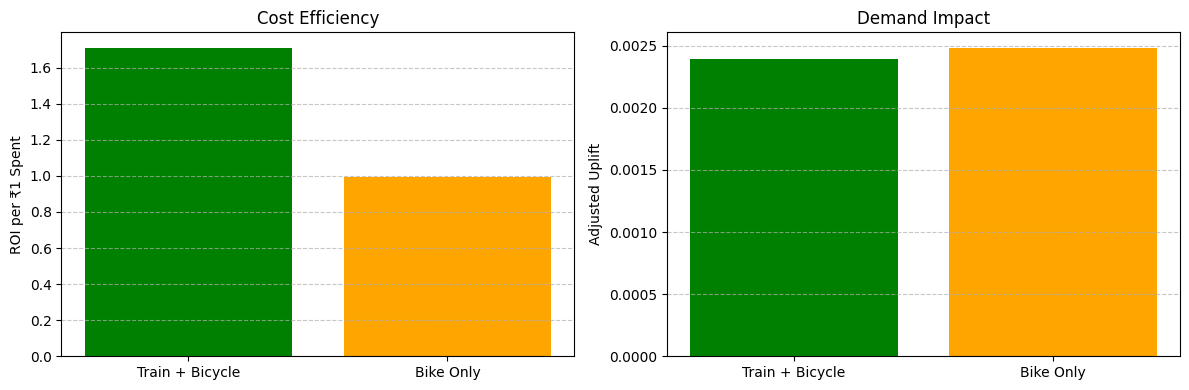

In [ ]:
import matplotlib.pyplot as plt


results_train = logistic_adjusted_uplift(group_sodepur, group_agarpara, 'train_bicycle')
results_bike = logistic_adjusted_uplift(group_sodepur, group_agarpara, 'bike_only')

labels = [results_train['Option'], results_bike['Option']]
roi_values = [results_train['ROI per ₹'], results_bike['ROI per ₹']]
uplift_values = [results_train['Adjusted Uplift'], results_bike['Adjusted Uplift']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(labels, roi_values, color=['green', 'orange'])
ax1.set_ylabel('ROI per ₹1 Spent')
ax1.set_title('Cost Efficiency')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2.bar(labels, uplift_values, color=['green', 'orange'])
ax2.set_ylabel('Adjusted Uplift')
ax2.set_title('Demand Impact')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()